# Movie Recommendation System

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from random import randrange
import math
import seaborn as sns

In [2]:
ratings_df=pd.read_csv('combined_data_1.txt', names = ['user_id', 'rating', 'date'])
ratings_df.head()
# print(ratings_df.shape)

,user_id,rating,date
0,1:,NaN,NaN
1,1488844,3.0,2005-09-06
2,822109,5.0,2005-05-13
3,885013,4.0,2005-10-19
4,30878,4.0,2005-12-26


Dataset Shape:  (24058263, 3)
Number of Movies: 4499
'5' Ratings: 5506583 percentage of total ratings 0.22892812118718717
'4' Ratings: 8085741 percentage of total ratings 0.33615283662049733
'3' Ratings: 6904181 percentage of total ratings 0.2870312105830921
'2' Ratings: 2439073 percentage of total ratings 0.10140088678013137
'1' Ratings: 1118186 percentage of total ratings 0.046486944829092026


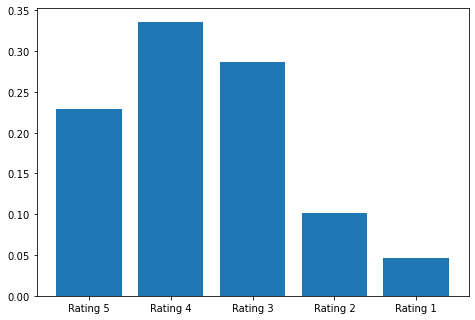

In [3]:
# exploratory analysis

print("Dataset Shape: ", ratings_df.shape)

rating_counts = ratings_df['rating'].value_counts(dropna = False)
print("Number of Movies:", rating_counts[np.nan])
print("'5' Ratings:", rating_counts[5], "percentage of total ratings",
      rating_counts[5]/(ratings_df.shape[0]-rating_counts[np.nan]))

print("'4' Ratings:", rating_counts[4], "percentage of total ratings",
      rating_counts[4]/(ratings_df.shape[0]-rating_counts[np.nan]))

print("'3' Ratings:", rating_counts[3], "percentage of total ratings",
      rating_counts[3]/(ratings_df.shape[0]-rating_counts[np.nan]))

print("'2' Ratings:", rating_counts[2], "percentage of total ratings",
      rating_counts[2]/(ratings_df.shape[0]-rating_counts[np.nan]))

print("'1' Ratings:", rating_counts[1], "percentage of total ratings",
      rating_counts[1]/(ratings_df.shape[0]-rating_counts[np.nan]))

fig = plt.figure()
ax=fig.add_axes([0,0,1,1])
rating = ['Rating 5', 'Rating 4','Rating 3','Rating 2','Rating 1']
nums=[rating_counts[5]/(ratings_df.shape[0]-rating_counts[np.nan]),
     rating_counts[4]/(ratings_df.shape[0]-rating_counts[np.nan]),
     rating_counts[3]/(ratings_df.shape[0]-rating_counts[np.nan]),
     rating_counts[2]/(ratings_df.shape[0]-rating_counts[np.nan]),
     rating_counts[1]/(ratings_df.shape[0]-rating_counts[np.nan])]
ax.bar(rating,nums)
plt.show()

In [4]:
movies_id = []
user_id = ratings_df['user_id'].tolist()
ratings_list = ratings_df['rating'].tolist()
# when rating_list is null user_id will have the movie_id in the same column
for i in range(len(ratings_list)):
    if (pd.isnull(ratings_list[i])):
        movie_id = user_id[i][:-1]
        movies_id.append(-1)
    else:
        movies_id.append(int(movie_id))

# add movie_id to dataframe
ratings_df['movie_id'] = movies_id
ratings_df

,user_id,rating,date,movie_id
0,1:,NaN,NaN,-1
1,1488844,3.0,2005-09-06,1
2,822109,5.0,2005-05-13,1
3,885013,4.0,2005-10-19,1
4,30878,4.0,2005-12-26,1
...,...,...,...,...
24058258,2591364,2.0,2005-02-16,4499
24058259,1791000,2.0,2005-02-10,4499
24058260,512536,5.0,2005-07-27,4499
24058261,988963,3.0,2005-12-20,4499


In [5]:
# drop all rows with NaN values, original movie ids are no longer needed
ratings_df = ratings_df.dropna()
ratings_df

,user_id,rating,date,movie_id
1,1488844,3.0,2005-09-06,1
2,822109,5.0,2005-05-13,1
3,885013,4.0,2005-10-19,1
4,30878,4.0,2005-12-26,1
5,823519,3.0,2004-05-03,1
...,...,...,...,...
24058258,2591364,2.0,2005-02-16,4499
24058259,1791000,2.0,2005-02-10,4499
24058260,512536,5.0,2005-07-27,4499
24058261,988963,3.0,2005-12-20,4499


In [6]:
# read the movie names into a separate dataframe (found encoding attribute on stack overflow after a certain error)
movies_df = pd.read_csv('movie_titles.csv', encoding = "ISO-8859-1", names = ['movie_id', 'year', 'movie_name'])
movies_df

,movie_id,year,movie_name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW
...,...,...,...
17765,17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004.0,Fidel Castro: American Experience
17767,17768,2000.0,Epoch
17768,17769,2003.0,The Company


In [7]:
# add movie_name to ratings df
movie_names = []
movie_ids = ratings_df['movie_id'].tolist()
for movie_id in movie_ids:
    movie_names.append(movies_df.at[movie_id - 1, 'movie_name'])
    

ratings_df['movie_name'] = movie_names
ratings_df

<ipython-input-7-58336e809a1f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['movie_name'] = movie_names


,user_id,rating,date,movie_id,movie_name
1,1488844,3.0,2005-09-06,1,Dinosaur Planet
2,822109,5.0,2005-05-13,1,Dinosaur Planet
3,885013,4.0,2005-10-19,1,Dinosaur Planet
4,30878,4.0,2005-12-26,1,Dinosaur Planet
5,823519,3.0,2004-05-03,1,Dinosaur Planet
...,...,...,...,...,...
24058258,2591364,2.0,2005-02-16,4499,In My Skin
24058259,1791000,2.0,2005-02-10,4499,In My Skin
24058260,512536,5.0,2005-07-27,4499,In My Skin
24058261,988963,3.0,2005-12-20,4499,In My Skin


In [8]:
ratings_df=ratings_df.drop('date', 1)
ratings_df

,user_id,rating,movie_id,movie_name
1,1488844,3.0,1,Dinosaur Planet
2,822109,5.0,1,Dinosaur Planet
3,885013,4.0,1,Dinosaur Planet
4,30878,4.0,1,Dinosaur Planet
5,823519,3.0,1,Dinosaur Planet
...,...,...,...,...
24058258,2591364,2.0,4499,In My Skin
24058259,1791000,2.0,4499,In My Skin
24058260,512536,5.0,4499,In My Skin
24058261,988963,3.0,4499,In My Skin


In [9]:
ratings_df = ratings_df.dropna()
ratings_df

,user_id,rating,movie_id,movie_name
1,1488844,3.0,1,Dinosaur Planet
2,822109,5.0,1,Dinosaur Planet
3,885013,4.0,1,Dinosaur Planet
4,30878,4.0,1,Dinosaur Planet
5,823519,3.0,1,Dinosaur Planet
...,...,...,...,...
24058258,2591364,2.0,4499,In My Skin
24058259,1791000,2.0,4499,In My Skin
24058260,512536,5.0,4499,In My Skin
24058261,988963,3.0,4499,In My Skin


In [10]:
x = ratings_df.movie_name.unique()
print("The number of unique movies in the dataframe: ", len(x))

The number of unique movies in the dataframe:  4471


In [11]:
ratings_df['movie_popularity'] = ratings_df['movie_name'].map(ratings_df['movie_name'].value_counts())
ratings_df

,user_id,rating,movie_id,movie_name,movie_popularity
1,1488844,3.0,1,Dinosaur Planet,547
2,822109,5.0,1,Dinosaur Planet,547
3,885013,4.0,1,Dinosaur Planet,547
4,30878,4.0,1,Dinosaur Planet,547
5,823519,3.0,1,Dinosaur Planet,547
...,...,...,...,...,...
24058258,2591364,2.0,4499,In My Skin,428
24058259,1791000,2.0,4499,In My Skin,428
24058260,512536,5.0,4499,In My Skin,428
24058261,988963,3.0,4499,In My Skin,428


In [12]:
temp_df = pd.value_counts(ratings_df.movie_name).to_frame().reset_index()
temp_df

,index,movie_name
0,Pirates of the Caribbean: The Curse of the Bla...,193941
1,What Women Want,162597
2,Bruce Almighty,160454
3,The Italian Job,156183
4,American Beauty,154832
...,...,...
4466,Ghost Hunters: Season 1,44
4467,Haven,43
4468,Expo: Magic of the White City,42
4469,Hazaaron Khwaishein Aisi,39


In [13]:
print("The average movie popularity is: ", temp_df['movie_name'].mean())
temp_df['percentile']=temp_df.movie_name.rank(pct=True)
temp_df = temp_df[temp_df['percentile'] >= 0.93] 
temp_df

The average movie popularity is:  5379.951688660255


,index,movie_name,percentile
0,Pirates of the Caribbean: The Curse of the Bla...,193941,1.000000
1,What Women Want,162597,0.999776
2,Bruce Almighty,160454,0.999553
3,The Italian Job,156183,0.999329
4,American Beauty,154832,0.999105
...,...,...,...
308,Encino Man,19799,0.931112
309,Home Alone 2: Lost in New York,19754,0.930888
310,A Fistful of Dollars,19620,0.930664
311,Dark City,19579,0.930441


In [14]:
min_mv = temp_df['movie_name'].min()
print("The minimum value of movie popularity for the most rated movies is: ", min_mv)

The minimum value of movie popularity for the most rated movies is:  19563


In [15]:
ratings_df = ratings_df[ratings_df['movie_popularity'] >= min_mv]
ratings_df

,user_id,rating,movie_id,movie_name,movie_popularity
52551,1392773,4.0,28,Lilo and Stitch,39752
52552,1697479,4.0,28,Lilo and Stitch,39752
52553,1990901,5.0,28,Lilo and Stitch,39752
52554,2626356,5.0,28,Lilo and Stitch,39752
52555,1402412,2.0,28,Lilo and Stitch,39752
...,...,...,...,...,...
24018724,480064,1.0,4488,Wonder Boys,33175
24018725,1021220,4.0,4488,Wonder Boys,33175
24018726,2186555,4.0,4488,Wonder Boys,33175
24018727,833254,3.0,4488,Wonder Boys,33175


In [16]:
from numpy import count_nonzero
mat_df = ratings_df.pivot_table(index='movie_name',columns='user_id',values='rating').fillna(0)
np_mat = mat_df.values
print(type(mat_df))
print(type(np_mat))

#sparsity calculation
sparsity = 1 - (count_nonzero(np_mat)/float(np_mat.size))
print("sparsity: ", sparsity)

mat_df.head(10)

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
sparsity:  0.8870826187865078


user_id,10,1000004,1000027,1000033,1000035,1000038,1000051,1000057,100006,1000062,...,999932,999935,999944,999945,999949,999964,999972,999977,999984,999988
movie_name,,,,,,,,,,,,,,,,,,,,,
10 Things I Hate About You,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2 Fast 2 Furious,2.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25th Hour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28 Days Later,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50 First Dates,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0
A Beautiful Mind,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
A Cinderella Story,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Fistful of Dollars,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Man Apart,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
#we will convert this dataframe to a sparse matrix, because, most of the values in the matrix are 0s
#this will only look at non-zero values, as that would imply some rating is present for that specific user and rating
movies_sm = csr_matrix(np_mat)
print(movies_sm)

  (0, 14)	3.0
  (0, 15)	5.0
  (0, 24)	4.0
  (0, 28)	4.0
  (0, 32)	2.0
  (0, 38)	5.0
  (0, 44)	5.0
  (0, 71)	5.0
  (0, 74)	5.0
  (0, 78)	3.0
  (0, 81)	3.0
  (0, 83)	5.0
  (0, 89)	5.0
  (0, 93)	3.0
  (0, 99)	4.0
  (0, 103)	5.0
  (0, 104)	2.0
  (0, 107)	3.0
  (0, 116)	3.0
  (0, 127)	4.0
  (0, 136)	4.0
  (0, 137)	5.0
  (0, 142)	1.0
  (0, 149)	3.0
  (0, 170)	3.0
  :	:
  (312, 463457)	3.0
  (312, 463462)	3.0
  (312, 463469)	4.0
  (312, 463485)	1.0
  (312, 463501)	5.0
  (312, 463502)	4.0
  (312, 463508)	3.0
  (312, 463523)	4.0
  (312, 463547)	5.0
  (312, 463557)	4.0
  (312, 463558)	4.0
  (312, 463563)	4.0
  (312, 463571)	4.0
  (312, 463606)	3.0
  (312, 463612)	4.0
  (312, 463645)	4.0
  (312, 463670)	5.0
  (312, 463721)	4.0
  (312, 463757)	3.0
  (312, 463758)	1.0
  (312, 463760)	3.0
  (312, 463786)	4.0
  (312, 463788)	4.0
  (312, 463803)	5.0
  (312, 463818)	4.0


In [18]:
movies_knn = NearestNeighbors(metric = 'cosine', algorithm = 'auto')
movies_knn.fit(movies_sm)
# print(type(movies_knn))

NearestNeighbors(metric='cosine')

In [19]:
#generating a random movie 
movie_list = list(mat_df.index)
rand_index = randrange(len(movie_list))
cur_movie = movie_list[rand_index]
print(cur_movie)

my_movie_arr = mat_df.loc[[cur_movie]].values

print(my_movie_arr)
print(my_movie_arr.shape)

Commando
[[0. 0. 0. ... 0. 0. 0.]]
(1, 463819)


In [20]:
print("Input Movie: ", cur_movie)
print("Movie index: ", rand_index)
top_recommendations = []
# print(my_movie_arr.shape)
kneighbors_output = movies_knn.kneighbors(my_movie_arr, n_neighbors = 7)
dist_list = kneighbors_output[0][0]
top_indexes = kneighbors_output[1][0]

for i in range(len(top_indexes)):
    midx = top_indexes[i]
    my_mv = movie_list[midx]
    if my_mv != cur_movie:
        top_recommendations.append(my_mv)

print("***RECOMMENDATIONS***")

for i in range(len(top_recommendations)):
    print(top_recommendations[i], ": ", dist_list[i])

Input Movie:  Commando
Movie index:  61
***RECOMMENDATIONS***
Under Siege :  1.3367085216486885e-13
Die Hard 2: Die Harder :  0.5694203752997571
The Scorpion King :  0.6190886729411149
Major League :  0.631635298693159
Superman: The Movie :  0.631976581852865
End of Days :  0.633326309643983


In [21]:
user_df = ratings_df.pivot_table(index='user_id',columns='movie_name',values='rating').fillna(0)
user_mat = user_df.values
print(type(user_df))
print(type(user_mat))

#sparsity calculation
sparsity = 1 - (count_nonzero(user_mat)/float(user_mat.size))
print("sparsity: ", sparsity)

user_df.head(10)

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
sparsity:  0.8870826187865078


movie_name,10 Things I Hate About You,2 Fast 2 Furious,25th Hour,28 Days Later,50 First Dates,A Beautiful Mind,A Cinderella Story,A Fistful of Dollars,A Man Apart,A Mighty Wind,...,Wayne's World,Whale Rider,What Women Want,When Harry Met Sally,While You Were Sleeping,Who Framed Roger Rabbit?: Special Edition,Wild Things,Wonder Boys,X2: X-Men United,Y Tu Mama Tambien
user_id,,,,,,,,,,,,,,,,,,,,,
10,0.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,5.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0
1000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000033,0.0,4.0,0.0,0.0,4.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
1000035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
user_sm = csr_matrix(user_mat)
print(user_sm.shape)

(463819, 313)


In [28]:
users_knn = NearestNeighbors(metric = 'cosine', algorithm = 'auto')
users_knn.fit(user_sm)

NearestNeighbors(metric='cosine')

In [25]:
user_list = list(user_df.index)
rand_idx = randrange(len(user_list))
cur_user = user_list[rand_idx]
print(cur_user)

my_user_arr = user_df.loc[[cur_user]].values

print(my_user_arr)
print(my_user_arr.shape)

90858
[[0. 3. 0. 0. 0. 2. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 5. 0. 0. 3. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 3. 3. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0.
  0. 0. 0. 0. 4. 0. 0. 0. 0. 0. 0. 0. 5. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 5. 0. 4. 0. 0. 0. 0. 0. 4. 0.
  0. 0. 0. 0. 0. 0. 4. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 3. 0. 0. 0. 0. 0. 4. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 3. 0. 2. 0. 0. 0. 0. 0. 0. 0. 3. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]]
(1, 313)


In [50]:
print("Input User: ", cur_user)
print("User index: ", rand_idx)

#computing the highest rated movie for the current user
cur_user_list = list(my_user_arr[0])
highest_rating = max(cur_user_list)
highest_rating_idx = cur_user_list.index(highest_rating)
fav_movie = movie_list[highest_rating_idx]
print("Input User's Favorite Movie: ", fav_movie)

top_users = []
top_movies = []

kneighbors_output_users = users_knn.kneighbors(my_user_arr, n_neighbors = 7)
distances = kneighbors_output_users[0][0]
top_indicies = kneighbors_output_users[1][0]

for i in range(len(top_indicies)):
    midx2 = top_indicies[i]
    my_usr = user_list[midx2]
    if my_usr != cur_user:
        top_users.append(my_usr)

print("***SIMILAR USERS***")

for i in range(len(top_users)):
    print(top_users[i], ": ", distances[i])

print("***RECOMMENDATIONS***")
for i in range(len(top_users)):
    userA = top_users[i]
    temp_usrlist = list(user_df.loc[[userA]].values)
    vals_list = list(temp_usrlist[0])
    max_movie = max(vals_list)
    max_idx = vals_list.index(max_movie)
    top_mv = movie_list[max_idx]
    if top_mv not in top_movies:
        top_movies.append(top_mv)
    else:
        vals_list.remove(max_movie)
        new_max = max(vals_list)
        max_idx2 = vals_list.index(new_max)
        top_mv2 = movie_list[max_idx2]
        top_movies.append(top_mv2)

for i in range(len(top_movies)):
    print(top_movies[i])

Input User:  90858
User index:  446014
Input User's Favorite Movie:  Army of Darkness
***SIMILAR USERS***
2006012 :  1.1102230246251565e-16
945099 :  0.4325829612400247
2088401 :  0.44989838924319003
1330405 :  0.4557366723817987
2211425 :  0.45829637169818727
181699 :  0.45949107187700344
***RECOMMENDATIONS***
Man on Fire
A Beautiful Mind
28 Days Later
Bad Boys
Alien: Collector's Edition
25th Hour


In [32]:
print(len(movie_list))

313
